In [1]:
import numpy as np
import sys,os
module_root = '..'
sys.path.append(module_root)
from settings import raw_folder, train_folder, intermediate_folder
import glob
import seaborn as sns
import SimpleITK as sitk
import pandas as pd
from ipywidgets import interact, widgets

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
cmap = colors.ListedColormap(['orange', 'red'])

In [24]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

In [3]:
folders_list = sorted(os.listdir(os.path.join(raw_folder, 'second attempt')))
type_dropdown = widgets.Dropdown(
    options=folders_list,
    value=folders_list[-1],
    description='source: ',
)
display(type_dropdown)

Dropdown(description='source: ', index=1, options=('test', 'train'), value='train')

In [8]:
folders_list = sorted(os.listdir(os.path.join(raw_folder, 'second attempt', type_dropdown.value)))
folder_dropdown = widgets.Dropdown(
    options=folders_list,
    value=folders_list[0],
    description='folder: ',
)
display(folder_dropdown)

Dropdown(description='folder: ', options=('1039-2088DA037-3', '1039-2088DA037-4', '1039-2088DA039-3', '1039-2088DA039-4'), value='1039-2088DA037-3')

In [9]:
annotation_folder = os.path.join(raw_folder,'second attempt', type_dropdown.value, folder_dropdown.value)
#print(annotation_folder)
#print(os.path.isdir(annotation_folder))
tifs = sorted(glob.glob( annotation_folder + '/*.tif'))
#print('no of tifs: {}'.format(len(tifs)))
#
images_dropdown = widgets.Dropdown(
    options=tifs,
    value=tifs[0],
    description='image: ',
)
display(images_dropdown)

Dropdown(description='image: ', options=('/media/deepinfer/mehrtash2/qanat/raw/second attempt/train/1039-2088DA037-3/1039-2088DA037-3.tif',), value='/media/deepinfer/mehrtash2/qanat/raw/second attempt/train/1039-2088DA037-3/1039-2088DA037-3.tif')

In [10]:
tif_path = images_dropdown.value
image = sitk.ReadImage(tif_path)
nda = sitk.GetArrayFromImage(image)

In [12]:
labels = sorted(glob.glob(raw_folder + '/' + os.path.basename(tif_path).split('.')[0] + '_label_*.nrrd'))
print('no of labels: {}'.format(len(labels)))
labels_dropdown = widgets.Dropdown(
    options=labels,
    value=labels[0],
    description='label: ',
)
display(labels_dropdown)

no of labels: 2


Dropdown(description='label: ', options=('/media/deepinfer/mehrtash2/qanat/raw/1039-2088DA037-3_label_1.nrrd', '/media/deepinfer/mehrtash2/qanat/raw/1039-2088DA037-3_label_2.nrrd'), value='/media/deepinfer/mehrtash2/qanat/raw/1039-2088DA037-3_label_1.nrrd')

In [13]:
label_path = labels_dropdown.value
label = sitk.ReadImage(label_path)
label_nda = sitk.GetArrayFromImage(label).squeeze()
label_mask = np.ma.masked_where(label_nda== 0, label_nda)

In [14]:
roi_path = label_path.replace('.nrrd', '_roi.acsv')
roi_points = np.zeros((2,2))
i = 0
with open(roi_path) as f:
    for line in f.readlines():
        if line.startswith('point'):
            p = line.split('|')
            roi_points[i,0] = -float(p[1])
            roi_points[i,1] = -float(p[2])
            i += 1
center = list(roi_points[0])
center = np.asarray(image.TransformPhysicalPointToIndex(center))
spacing = image.GetSpacing()
length = np.abs(roi_points[1]/spacing).astype(np.int)
start = center - length
end = center + length

In [18]:
roi_nda= nda[start[1]:end[1], start[0]:end[0]]
roi_mask_nda = label_mask[start[1]:end[1], start[0]:end[0]]
roi_image = sitk.GetImageFromArray(roi_nda)
roi_mask = sitk.GetImageFromArray(roi_mask_nda)
roi_mask.CopyInformation(roi_image)

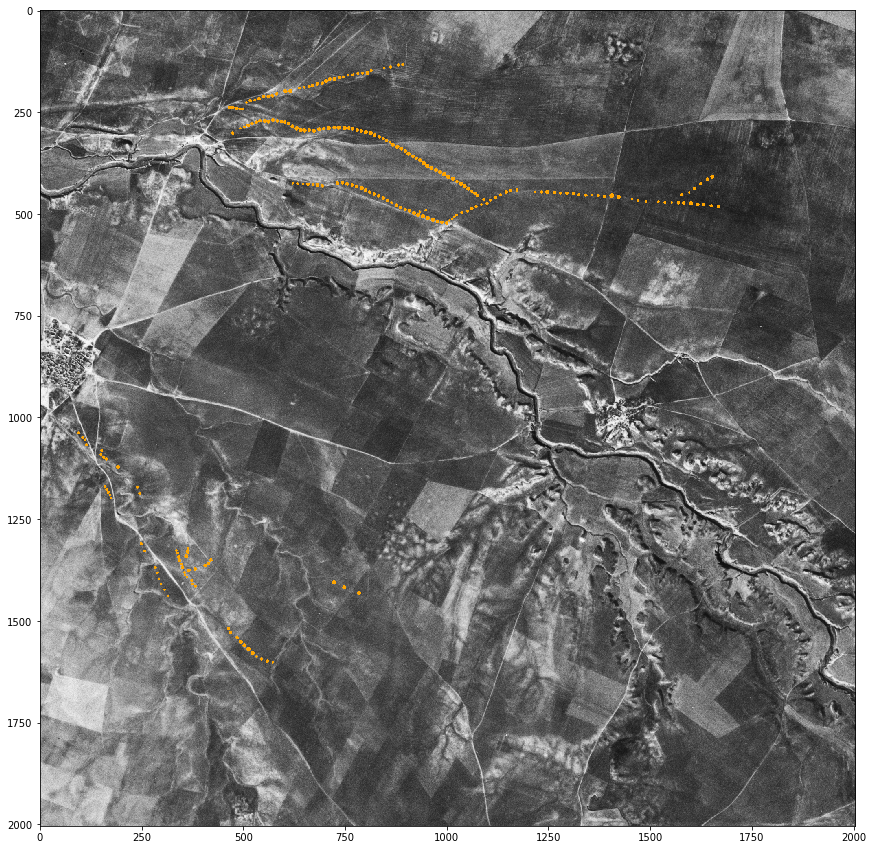

In [23]:
#
plt.figure(figsize=(15,15))
plt.imshow(roi_nda, cmap=plt.cm.gray)
plt.imshow(roi_mask_nda, alpha=1, cmap=cmap)

In [31]:
hough_radii = np.arange(1, 2, 1)
hough_res = hough_circle(roi_mask_nda, hough_radii)
# Select the most prominent 5 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=1000)

label_circles = np.zeros(label_mask1.shape)
for center_y, center_x, radius in zip(cy, cx, radii):
    #label_circles[center_y-1:center_y, center_x-1:center_x] = 1
    circy, circx = circle_perimeter(center_y, center_x, radius)
    label_circles[circy, circx] = 1

In [32]:
print(np.sum(label_circles))

0.0


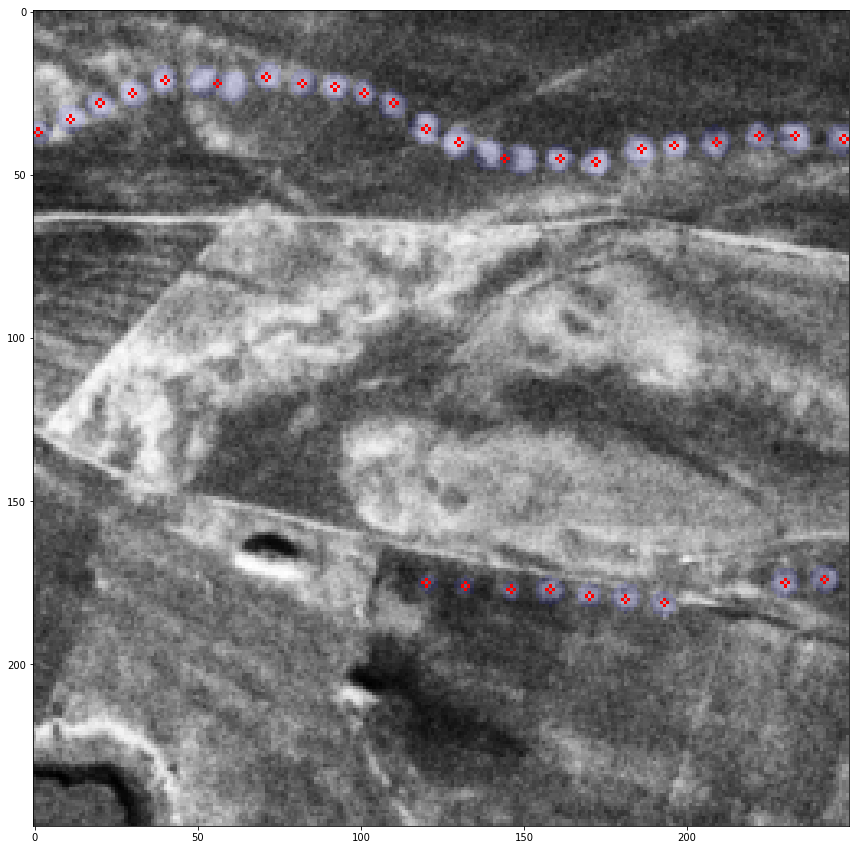

In [50]:
plt.figure(figsize=(15,15))
cmap1 = colors.ListedColormap(['blue', 'red'])
cmap2 = colors.ListedColormap(['red', 'red'])
plt.imshow(roi_nda[250:500, 500:750],alpha=1, cmap=plt.cm.gray)
roi_mask_nda = np.ma.masked_where(roi_mask_nda== 0, roi_mask_nda)
label_circles = np.ma.masked_where(label_circles== 0, label_circles)
plt.imshow(roi_mask_nda[250:500, 500:750],alpha=0.1,cmap=cmap1)
plt.imshow(label_circles[250:500, 500:750],alpha=1, cmap=cmap2)